### Quantification and Preliminary Analysis of Jurkat Cell Line

From Sam@Sanford: 

The samples are Jurkat cells.  
* J1 vs J2 signify replicate experiments.
* PLKO is the control (So J1 PLKO and J2 PLKO should be the same)
* H2 and H5 are two independent shRNAs to knockdown ARID5B.

"By using duplicate shRNA genes that are changed similarly by both shRNA constructs are more likely to be directly linked to ARID5B whereas genes that are only affected by one shRNA or the other would be more concerning for off-target effects. Would be interesting to see if loss of Arid5b shows any particular pathway changes."

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import h5py
import requests

### Install Kallisto and Process Samples

In [56]:
# Download and install kallisto and the same index used in cgl-rnaseq
!wget -q -qO- https://github.com/pachterlab/kallisto/releases/download/v0.43.0/kallisto_linux-v0.43.0.tar.gz | \
    tar -xz kallisto_linux-v0.43.0/kallisto --strip-components=1
!wget -q -N  http://hgdownload.soe.ucsc.edu/treehouse/reference/kallisto_hg38.idx

In [42]:
!ls fastq

J1-D6-H2_S11_concatenated.R1.fastq.gz	J2-D7-H2_S1_concatenated.R1.fastq.gz
J1-D6-H5_S5_concatenated.R1.fastq.gz	J2-D7-H5_S12_concatenated.R1.fastq.gz
J1-D6-PLKO_S3_concatenated.R1.fastq.gz	J2-D7-PLKO_S9_concatenated.R1.fastq.gz


In [3]:
samples = ["J1-D6-PLKO_S3", "J2-D7-PLKO_S9", "J1-D6-H2_S11", "J2-D7-H2_S1", "J1-D6-H5_S5", "J2-D7-H5_S12"]

In [46]:
%%time
# Run kallisto - fragment length and standard deviation just plugged in for now
for sample in samples:
    print("Running Kallisto on {}".format(sample))
    !./kallisto quant -i kallisto_hg38.idx --single -l 200 -s 20 -t 8 \
        -o {sample} fastq/{sample}_concatenated.R1.fastq.gz 

Running Kallisto on J1-D6-PLKO_S3

[quant] fragment length distribution is truncated gaussian with mean = 200, sd = 20
[index] k-mer length: 31
[index] number of targets: 197,044
[index] number of k-mers: 115,344,928
[index] number of equivalence classes: 750,215
[quant] running in single-end mode
[quant] will process file 1: fastq/J1-D6-PLKO_S3_concatenated.R1.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 41,820,730 reads, 29,262,898 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,178 rounds

Running Kallisto on J2-D7-PLKO_S9

[quant] fragment length distribution is truncated gaussian with mean = 200, sd = 20
[index] k-mer length: 31
[index] number of targets: 197,044
[index] number of k-mers: 115,344,928
[index] number of equivalence classes: 750,215
[quant] running in single-end mode
[quant] will process file 1: fastq/J2-D7-PLKO_S9_concatenated.R1.fastq.gz
[quant] finding ps

### Load Output into a Pandas Dataframe
We load using the h5 output as its orders of magnitude faster then tsv. The index is transcript identifiers as binary strings which speeds up indexing when handling the dataframe, but means you need to use b'NAME' when doing a lookup.

In [20]:
# See https://github.com/blachlylab/ursaminer/blob/master/ursa.py
quants = [h5py.File("{}/abundance.h5".format(sample), 'r') for sample in samples]
divisors = [(q["est_counts"][:] / q["aux"]["eff_lengths"][:]).sum() for q in quants]
tpms = {s: ((q["est_counts"][:] / q["aux"]["eff_lengths"][:]) / d) * 1e6 for s, q, d in zip(samples, quants, divisors)}

In [186]:
expression = pd.DataFrame(tpms, index=quants[0]["aux"]["ids"], columns=samples, dtype=np.float32)
expression.head()

,J1-D6-PLKO_S3,J2-D7-PLKO_S9,J1-D6-H2_S11,J2-D7-H2_S1,J1-D6-H5_S5,J2-D7-H5_S12
/aux/ids,,,,,,
b'ENST00000619216.1',0.0,0.0,0.0,0.000000,0.0,0.0
b'ENST00000473358.1',0.0,0.0,0.0,0.043979,0.0,0.0
b'ENST00000469289.1',0.0,0.0,0.0,0.000000,0.0,0.0
b'ENST00000607096.1',0.0,0.0,0.0,0.000000,0.0,0.0
b'ENST00000417324.1',0.0,0.0,0.0,0.000000,0.0,0.0


In [23]:
expression.describe()

,J1-D6-PLKO_S3,J2-D7-PLKO_S9,J1-D6-H2_S11,J2-D7-H2_S1,J1-D6-H5_S5,J2-D7-H5_S12
count,197044.000000,197044.000000,197044.000000,197044.000000,1.970440e+05,197044.000000
mean,5.075009,5.075009,5.075009,5.075009,5.075009e+00,5.075009
std,591.305123,556.174888,593.896436,570.984528,4.976624e+02,602.283463
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,0.019011,0.009678,0.010393,0.012371,8.485389e-08,0.009999
75%,0.504582,0.542256,0.462218,0.498688,6.337851e-01,0.463845
max,176172.445809,167875.171367,171568.555304,159695.127392,1.461979e+05,177759.122936


### Verify concordance of replicate controls

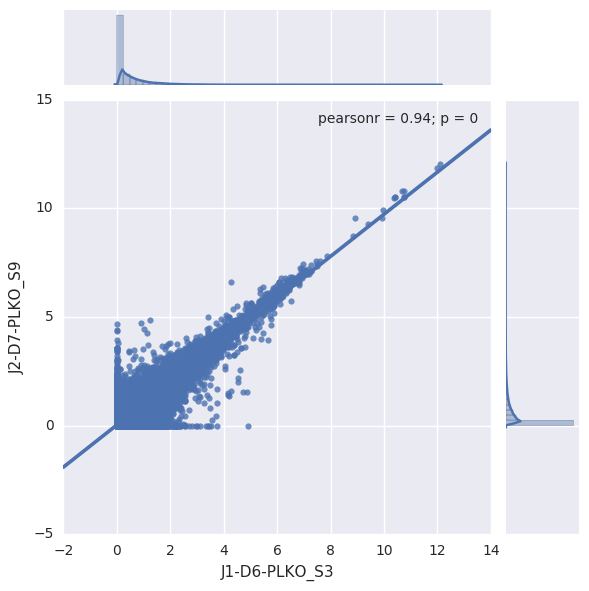

In [24]:
sns.jointplot(expression[samples[0]].apply(lambda x: np.log(x+1)),
              expression[samples[1]].apply(lambda x: np.log(x+1)), 
              kind='reg')
plt.xlabel(samples[0])
plt.ylabel(samples[1]);

In [193]:
# Get a list of transcripts associated with ARID5B using ensemble's REST API
gene = "ARID5B"
r = requests.get("https://rest.ensembl.org/lookup/symbol/homo_sapiens/{}".format(gene),
                 headers={"Content-Type": "application/json"})
assert(r.status_code == requests.codes.ok)
geneid = r.json()["id"]

r = requests.get("https://rest.ensembl.org/overlap/id/{}?feature=transcript".format(geneid),
                 headers={"Content-Type": "application/json"})
assert(r.status_code == requests.codes.ok)
transcripts = ["{}.{}".format(t["transcript_id"], t["version"]).encode() for t in r.json()]
print("Hugo: {} Ensemble: {} Transcripts: {}".format(gene, geneid, transcripts))

Hugo: ARID5B Ensemble: ENSG00000150347 Transcripts: [b'ENST00000279873.11', b'ENST00000309334.5']


In [194]:
# See if ARID5B has been knocked down
expression.loc[transcripts].head()

,J1-D6-PLKO_S3,J2-D7-PLKO_S9,J1-D6-H2_S11,J2-D7-H2_S1,J1-D6-H5_S5,J2-D7-H5_S12
/aux/ids,,,,,,
b'ENST00000279873.11',9.115992,9.726129,5.467342,5.068781,7.519782,5.164114
b'ENST00000309334.5',3.494813,3.712079,0.227074,0.818066,0.609754,0.245844
